In [96]:

import pymysql.cursors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyecharts.charts import Bar,Gauge,Pie,Page,Funnel,Geo,Scatter3D,Tab,Timeline,Grid,Line
from flask import Flask, render_template
from pyecharts import options as opts
# from jinja2.utils import markupsafe
from pyecharts.globals import CurrentConfig
from pyecharts.globals import ThemeType
import traceback
import PIL.Image as image
from wordcloud import STOPWORDS, WordCloud

# 获取数据库连接
db = pymysql.connect(host='localhost',
                    user='root',
                    password='233333',
                    db='buildingdata',
                    charset='utf8mb4')
try:
    #获取会话指针
    with db.cursor() as cursor:
        #查询语句
        sql = "select `小区名称`,`详细地址`,`所在区`,`均价`,`房屋面积`,`房屋朝向` from `buildingdata`"
        #查询所有行数
        # count = cursor.execute(sql)
        # print(count)
        #查询前三条数据
        # result = cursor.fetchmany(size=3)
        # print(result)
        cursor.execute(sql)
        result = cursor.fetchall()
        #执行结果转换为dataframe对象
        df = pd.DataFrame(list(result),columns=['小区名称','详细地址','所在区','均价','房屋面积','房屋朝向'])
        df0 = df.groupby('所在区').count()#用于统计各区域房屋正在销售的数量
        df1 = df.groupby('房屋朝向').count()#用于统计房屋朝向数量
        df2 = df[['所在区','均价']]
        df3 = df2.groupby('所在区')['均价'].mean().reset_index()
        df4 = df[['小区名称','均价']]
        df5 = df[['房屋朝向','均价']]
        df6 = df4.sort_values('均价', ascending=False)
        print(df.describe())
        print(df6)
finally:
    db.close()



                 均价
count    420.000000
mean   46592.857143
std    16466.171192
min    23800.000000
25%    29000.000000
50%    49400.000000
75%    55000.000000
max    87000.000000
          小区名称       均价
164  城投珠江·天河壹品  87000.0
360  城投珠江·天河壹品  87000.0
234  城投珠江·天河壹品  87000.0
24   城投珠江·天河壹品  87000.0
192  城投珠江·天河壹品  87000.0
..         ...      ...
176  广州城投·城隽雅苑  23800.0
120  广州城投·城隽雅苑  23800.0
372  广州城投·城隽雅苑  23800.0
316  广州城投·城隽雅苑  23800.0
288  广州城投·城隽雅苑  23800.0

[420 rows x 2 columns]


In [123]:
#创建柱状图
def bar_base() -> Bar:
    color_list = ['#D028DA', '#42C0FB', '#FEB64D', '#24D8B4', '#F85D63']
    c = (
        Bar(init_opts=opts.InitOpts(theme=ThemeType.WONDERLAND))
       .add_xaxis(list(df0.index))
       .add_yaxis("",
                   list(df0.iloc[:,0]),
                   markline_opts= opts.MarkLineItem(type_="average", name="平均值")
                   )
       .set_global_opts(title_opts=opts.TitleOpts(title="各区域房屋销售数量", subtitle=""))
       .set_series_opts(itemstyle_opts=[opts.ItemStyleOpts(color=color) for color in color_list]) 
   )
    return c
 
bar_base().render_notebook()

In [128]:
top_n = 100  # 指定排行榜数量
top_data = df6.head(top_n)  # 提取前top_n条数据
def bar_base() -> Bar:
    c = (
        Bar(init_opts=opts.InitOpts(theme=ThemeType.WONDERLAND))
       .add_xaxis(list(top_data['小区名称']))
       .add_yaxis("",
                   list(top_data['均价'])
                   )
       .set_global_opts(title_opts=opts.TitleOpts(title="房屋销售均价排行榜", subtitle=""))
       .set_series_opts(label_opts=opts.LabelOpts(is_show=False)) # 将标签的显示设置为False
   )
    return c
 
bar_base().render_notebook()

In [116]:
#创建饼图
def pie_base() -> Pie:
    c = (
        Pie(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
           .add(
            "",
            # [list(z) for z in zip(Faker.choose(), Faker.values())],
           [list(z) for z in zip(list(df1.index), list(df1.iloc[:, 0]))],
            radius=["30%", "70%"],
       )
           .set_global_opts(
            title_opts=opts.TitleOpts(title="房屋朝向数"),
            legend_opts=opts.LegendOpts(orient="vertical", pos_top="20%", pos_left="2%"),
       )
           .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}",color='#D028DA'))
           
   )
    return c
pie_base().render_notebook()

In [115]:
def line_base() -> Line:
    c = (
        Line(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
            .add_xaxis(list(df3['所在区']))
            .add_yaxis('各地区房屋每平方米售价',list(df3['均价']))
            
            .set_global_opts(title_opts=opts.TitleOpts(title="各地区房屋每平方米售价"))    
 
        )
    return c
line_base().render_notebook()

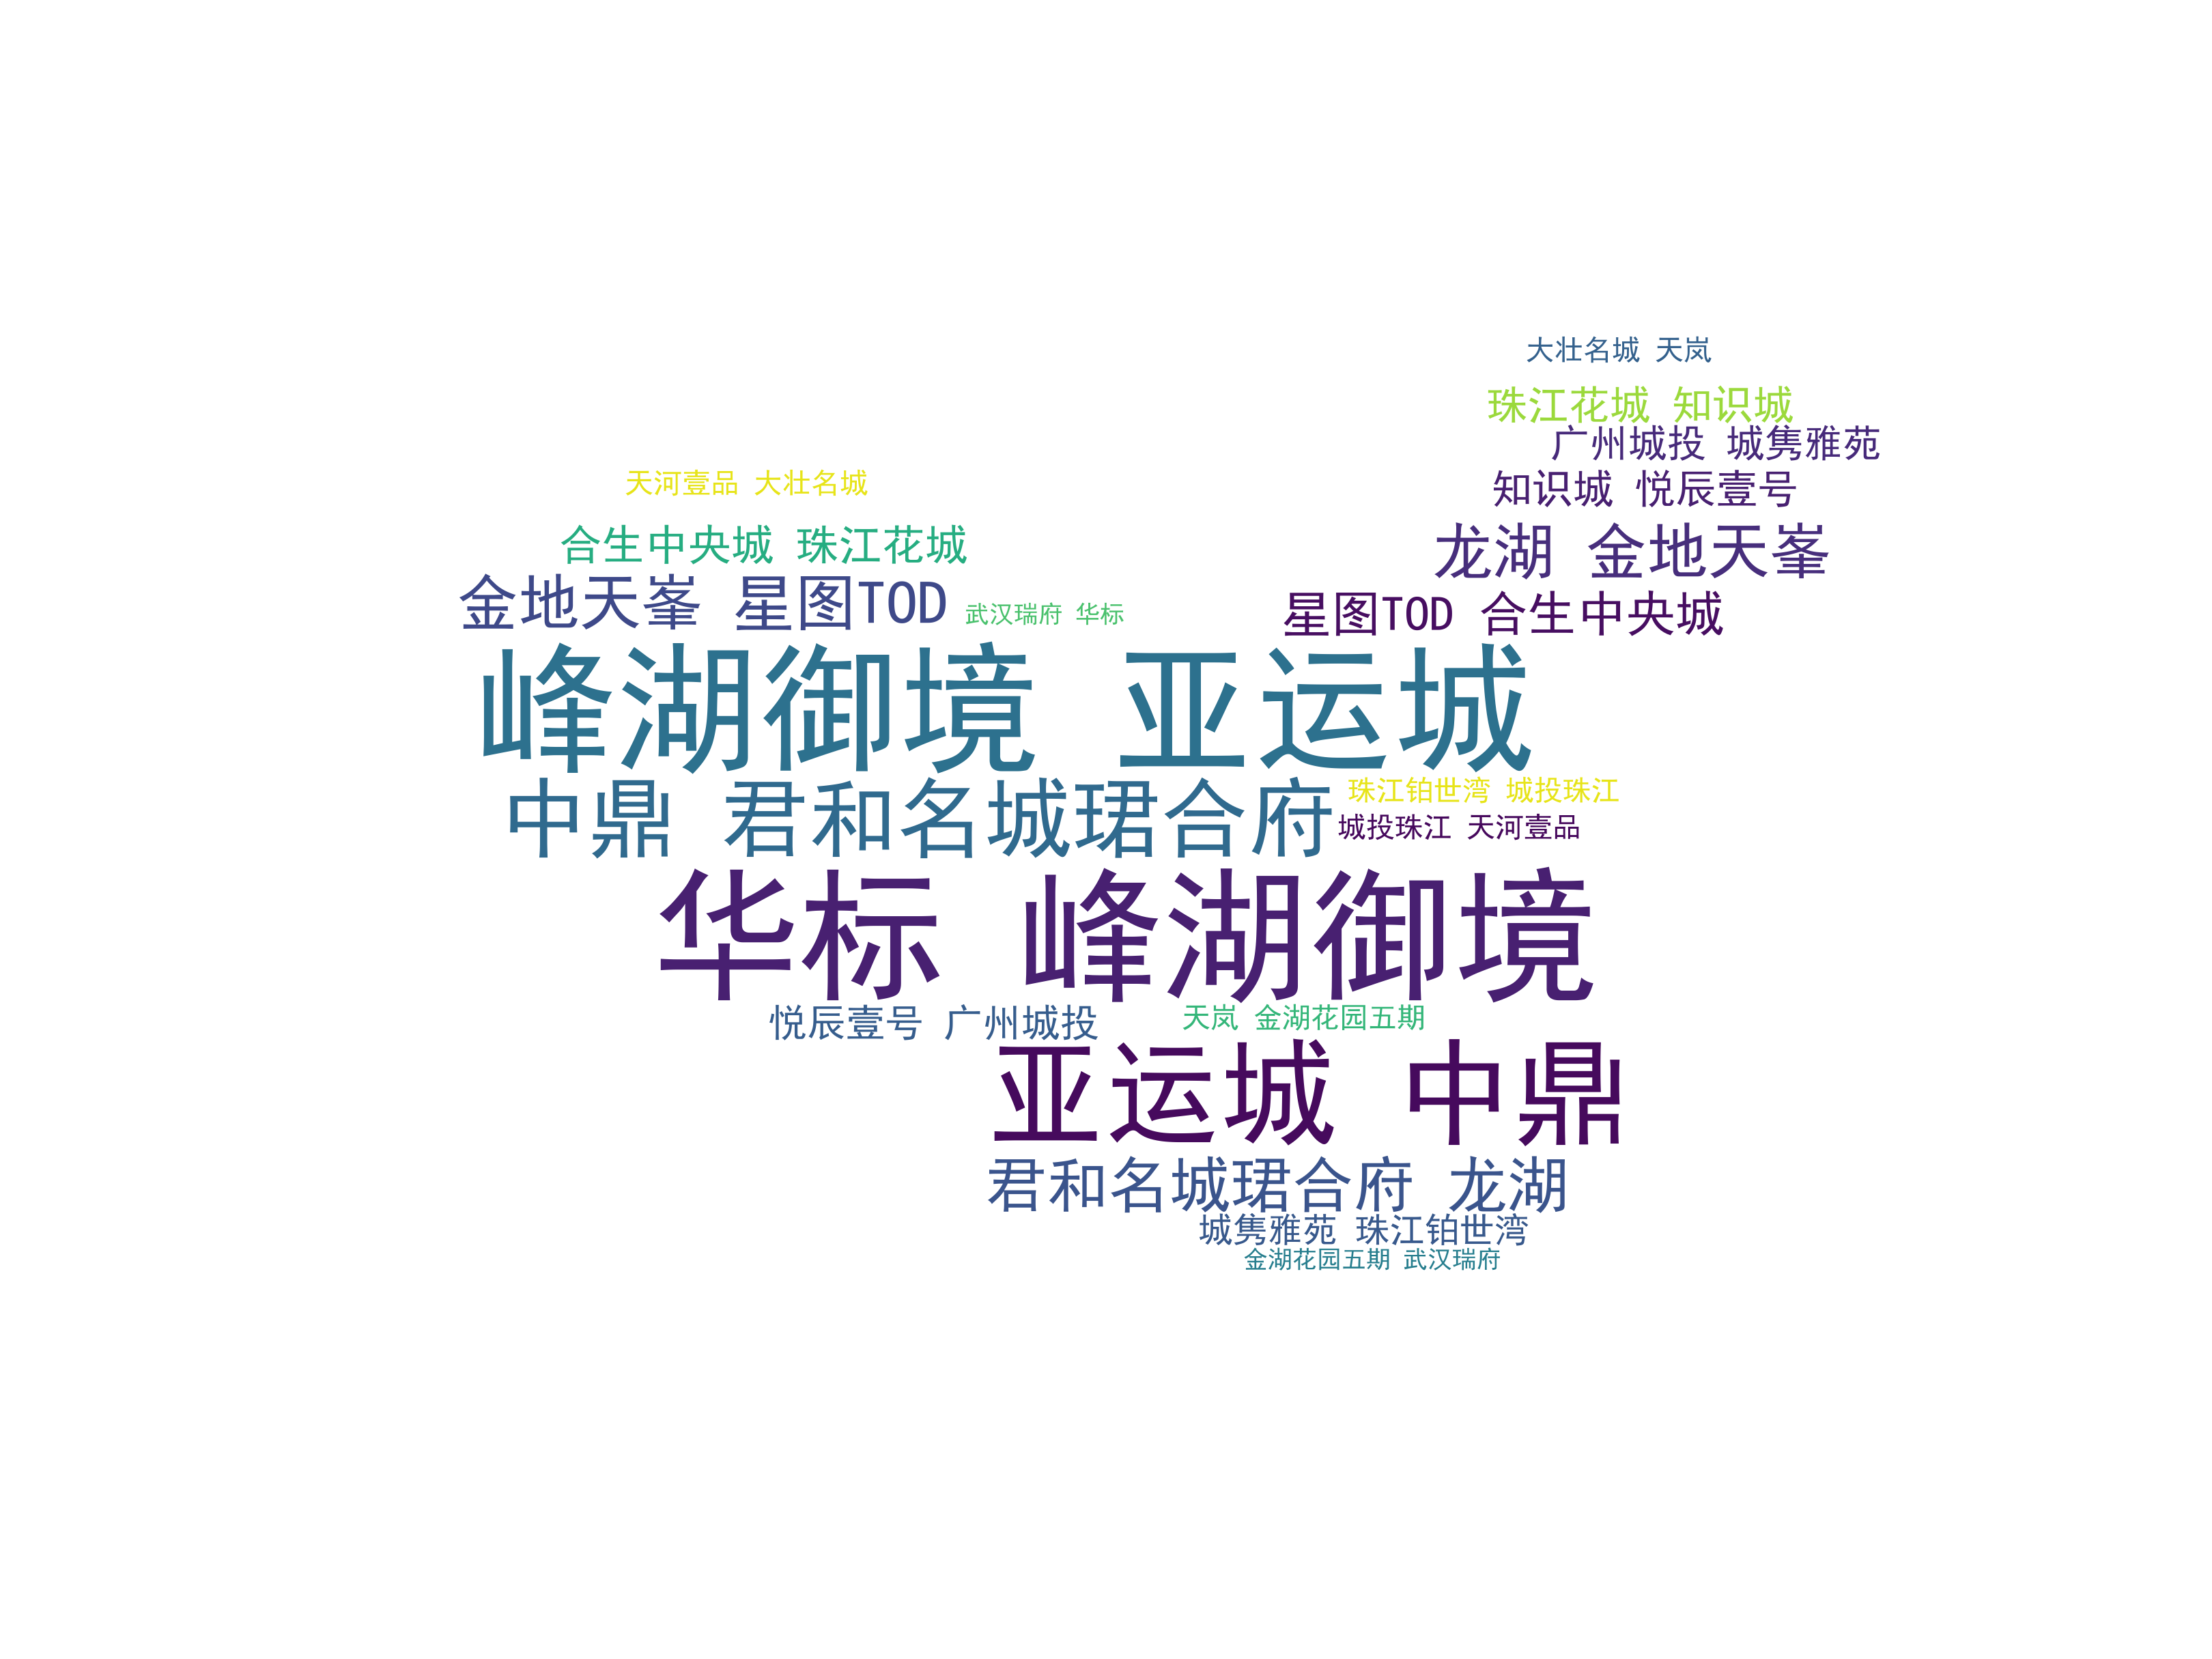

In [114]:
ComName_list = df['小区名称'].values.tolist()
ComName_str = ' '.join(ComName_list)
stopwords = []  # 停用词
backgroud_Image = np.array(image.open('./timg3.jpg'))  # 读取背景图片pic_path = "./timg3.jpg"
wc = WordCloud(
    scale=3,  # 清晰度
    background_color="white",  # 背景颜色
    max_words=2000,#最大字符数
    width=800,  # 图宽
    height=500,  # 图高
    font_path='C:/Windows/Fonts/SimHei.ttf',  # 字体文件路径，根据实际情况替换C:\Windows\Fonts\simfang.ttf
    stopwords=stopwords,  # 停用词
    mask=backgroud_Image  # 背景图片
)
wc.generate_from_text(ComName_str)  # 生成词云图
wc.to_file('广州小区名称词云图.png')  # 保存图片
wc.to_image()  # 显示图片

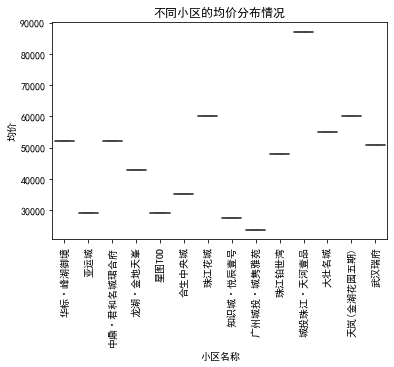

In [113]:
sns.boxplot(x='小区名称', y='均价', data=df4)
plt.title('不同小区的均价分布情况')
plt.xlabel('小区名称')
plt.ylabel('均价')
plt.xticks(rotation=90)  # 旋转x轴标签，以便更好地显示
plt.show()

In [7]:
import pymysql.cursors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyecharts.charts import Bar,Gauge,Pie,Page,Funnel,Geo,Scatter3D,Tab,Timeline,Grid,Line
from flask import Flask, render_template
from pyecharts import options as opts
# from jinja2.utils import markupsafe
from pyecharts.globals import CurrentConfig
from pyecharts.globals import ThemeType
import traceback
import PIL.Image as image
from wordcloud import STOPWORDS, WordCloud

# 获取数据库连接
db = pymysql.connect(host='192.168.22.135',
                    user='root',
                    password='a',
                    db='spark',
                    charset='utf8mb4')
try:
    #获取会话指针
    with db.cursor() as cursor:
        #查询语句
        sql = "select * from `user_meal`"
        cursor.execute(sql)
        result = cursor.fetchall()
        df = pd.DataFrame(list(result),columns=['UserID_Index','MealID_Index','Rating'])
        print(df)
        # sql1 = "select * from `Rating_count`"
        # cursor.execute(sql1)
        # result1 = cursor.fetchall()
        # print(result1)
finally:
    db.close()

       UserID_Index  MealID_Index     Rating
0              1580           537  18.912382
1              1580           527  17.694662
2              1580           207  16.767729
3              1580           269  16.723392
4              1580           272  16.446684
...             ...           ...        ...
51295            89           774  15.668370
51296            89           987  15.366119
51297            89           961  15.095916
51298            89           575  15.050333
51299            89          1028  15.045086

[51300 rows x 3 columns]


In [16]:
# 获取具有相同UserID_Index的MealID_Index集合
meal_id_sets = df.groupby('UserID_Index')['MealID_Index'].unique()

# 打印结果
print(meal_id_sets)


UserID_Index
0       [601, 400, 851, 907, 950, 358, 1209, 642, 1078...
1       [517, 746, 1597, 706, 169, 1139, 976, 139, 743...
2       [794, 851, 382, 790, 400, 338, 947, 949, 1108,...
3       [582, 679, 145, 1149, 472, 1466, 975, 253, 153...
4       [518, 484, 305, 582, 912, 843, 276, 504, 467, ...
                              ...                        
5125    [853, 921, 837, 624, 847, 526, 542, 613, 588, ...
5126    [551, 652, 474, 254, 763, 1059, 977, 1175, 892...
5127    [794, 551, 588, 527, 917, 723, 1108, 558, 987,...
5128    [479, 855, 678, 135, 767, 546, 527, 703, 787, ...
5129    [1351, 1046, 698, 511, 735, 768, 865, 274, 856...
Name: MealID_Index, Length: 5130, dtype: object


In [19]:
import pymysql.cursors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyecharts.charts import Bar,Gauge,Pie,Page,Funnel,Geo,Scatter3D,Tab,Timeline,Grid,Line
from flask import Flask, render_template
from pyecharts import options as opts
# from jinja2.utils import markupsafe
from pyecharts.globals import CurrentConfig
from pyecharts.globals import ThemeType
import traceback
import PIL.Image as image
from wordcloud import STOPWORDS, WordCloud

# 获取数据库连接
db = pymysql.connect(host='192.168.22.135',
                    user='root',
                    password='a',
                    db='spark',
                    charset='utf8mb4')
try:
    #获取会话指针
    with db.cursor() as cursor:
        sql = "select * from All_data"
        cursor.execute(sql)
        result = cursor.fetchall()
        #执行结果转换为dataframe对象
        df = pd.DataFrame(list(result),columns=['UserID','Rating','ReviewTime','Review','MealID','MealID_Index','UserID_Index'])
        print(df)
finally:
    db.close()

               UserID Rating  ReviewTime      Review      MealID  \
0      A2WOH395IHGS0T      5  1496177056  风味独特，真的不错！  B0040HNZTW   
1      A32KHS0VN0N0HB      3  1496177108   有特色，也比较卫生  B006Z48TZS   
2       A1YQ4Z5U9NIGP      5  1496177276    家常美味，推荐！  B00CDBTQCW   
3      A3E5V5TSTAY3R9      4  1496179256          好吃  B00751IYQ4   
4      A1V50CTTDJ73ZM      5  1496180009        不得不赞  B00C0OLT6S   
...               ...    ...         ...         ...         ...   
38379  A3UDYY6L2NH3JS      5  1498760000       好吃又划算  B000JO9JHW   
38380  A3A4WQL80WOTMH      5  1498760000        家常味道  B002C4Y3DC   
38381  A1VF5LN6SHFVFJ      5  1498760000     同事们都很喜欢  B000JO9JHW   
38382   AIETV2MBRE5E2      4  1498761601      美味，推荐！  B00FDWGMIE   
38383   AGODHOIFUGSLS      4  1498761812       真得不错！  B007UXSDT0   

       MealID_Index  UserID_Index  
0              57.0        2749.0  
1              11.0        4327.0  
2               4.0        2472.0  
3             557.0        2886.0  
4  

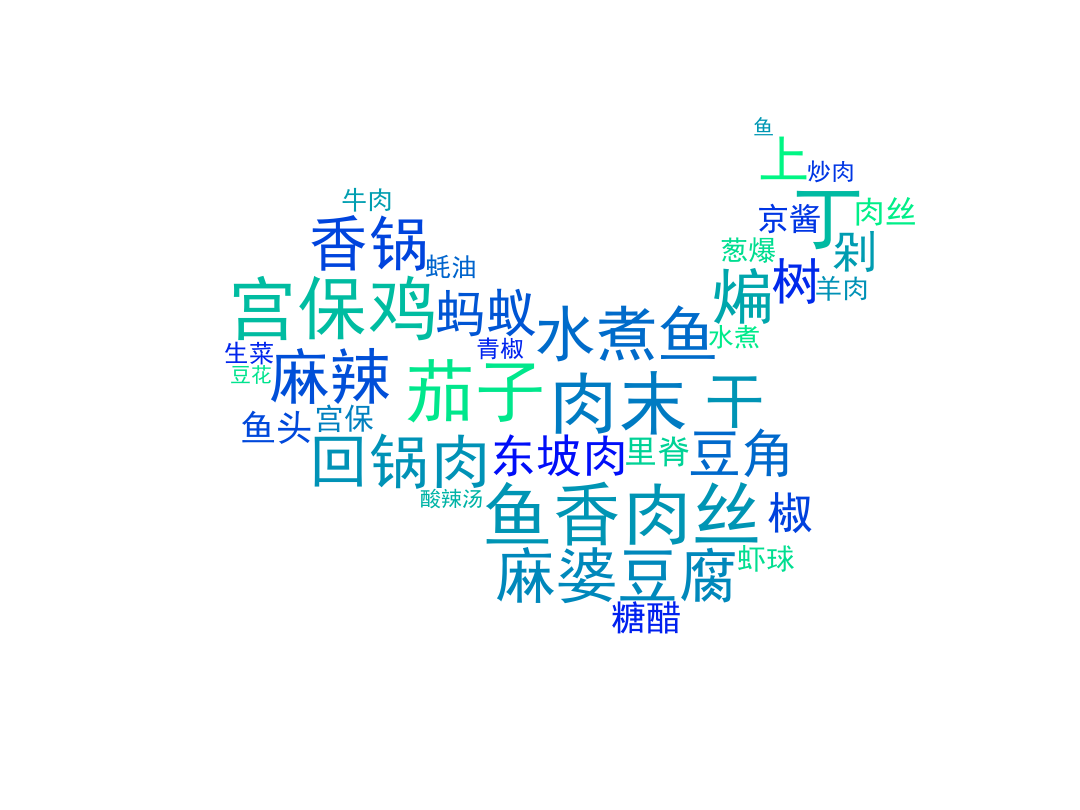

In [26]:
import jieba
from wordcloud import WordCloud
from PIL import Image
MealName = ["鱼香肉丝", "肉末茄子", "宫保鸡丁", "麻婆豆腐", "回锅肉", "水煮鱼", "麻辣香锅", "干煸豆角", "蚂蚁上树", "东坡肉","剁椒鱼头","糖醋里脊","京酱肉丝","宫保虾球","葱爆羊肉","水煮牛肉","蚝油生菜","青椒炒肉","酸辣汤","豆花鱼"]
Review = MealName
Review_content = ','.join([str(til.replace(' ', '')) for til in Review])
cut_text = jieba.cut(Review_content)
result = ' '.join(cut_text)
shape = np.array(Image.open("timg3.jpg"))
wc = WordCloud(font_path="simhei.ttf", max_font_size=70, background_color='white', colormap='winter',
               prefer_horizontal=1, mask=shape, relative_scaling=0.1)
wc.generate(result)
# wc.to_file("second_house_title.png")
# wc.to_file("Review_content.png")
wc.to_file("Meal_names.png")
wc.to_image()